# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# SEGUNDA PARTE: EXPLORAR CON TÓPIC MODELING

## I. Declaración de librerías

In [1]:
# Librerías de apoyo
# ==============================================================================
from tqdm import tqdm

# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mglearn

# Tratamiento de texto
# ==============================================================================
from nltk import FreqDist
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# otras configuraciones
# ==============================================================================
tqdm.pandas()

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 707 ms, sys: 64.1 ms, total: 771 ms
Wall time: 770 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary
337,SUPERINTENDENCIA NACIONAL DE CONTROL DE SERVIC...,RESOLUCION N° 592-2021-SUCAMEC,08/08/2021,Aprueban la Directiva que establece lineamient...,"Lima, 7 de agosto de 2021 VISTOS: Los Informes...",lima agosto visto informe técnico sucamec gepp...,lima agosto vistos informes técnicos sucamec g...,aprueban directiva establece lineamientos gest...
3699,SUPERINTENDENCIA NACIONAL DE MIGRACIONES,RESOLUCION N° 000124-2021-MIGRACIONES,31/05/2021,Designan Jefe de Control Migratorio del Aeropu...,"Breña, 28 de mayo del 2021 VISTO: El Memorando...",breña mayo visto memorando dirop migración dir...,breña mayo visto memorando dirop migraciones d...,designan jefe control migratorio aeropuerto in...
1370,TRANSPORTES Y COMUNICACIONES,RESOLUCION MINISTERIAL N° 696-2021-MTC/01.02,18/07/2021,Aprueban la ejecución de expropiación de áreas...,"Lima, 15 de julio de 2021 VISTA: La Nota de El...",lima julio visto nota elevación dirección ejec...,lima julio vista nota elevación dirección ejec...,aprueban ejecución expropiación áreas inmueble...
3921,MUNICIPALIDAD DE LURIN,ORDENANZA N° 419-2021/MDL,27/05/2021,Ordenanza que reglamenta el régimen jurídico d...,"Lurín, 29 de abril de 2021 EL ALCALDE DE LA MU...",lurín abril alcalde municipalidad distrital lu...,lurín abril alcalde municipalidad distrital lu...,ordenanza reglamenta régimen jurídico canes re...
1532,MUJER Y POBLACIONES VULNERABLES,DECRETO SUPREMO N° 012-2021-MIMP,15/07/2021,Decreto Supremo que aprueba la Sección Primera...,EL PRESIDENTE DE LA REPUBLICA CONSIDERANDO: Qu...,presidente republico marco modernización gesti...,presidente republica marco modernización gesti...,decreto supremo aprueba sección primera reglam...


In [3]:
# Limpieza del dataset
print("Dimensiones:", dataset_base.shape)
print("Filas que no contiene valores nulos:", len(dataset_base[dataset_base.content_for_topic.notna()]))
print("Filas con valores nulos:", len(dataset_base[dataset_base.isnull().any(axis=1)]))

Dimensiones: (4099, 8)
Filas que no contiene valores nulos: 4063
Filas con valores nulos: 36


In [4]:
# Eliminado los que contien valores nulos
dataset_base.dropna(inplace=True)
print("Dimensiones:", dataset_base.shape)

Dimensiones: (4063, 8)


In [5]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4063


CPU times: user 330 ms, sys: 640 µs, total: 331 ms
Wall time: 326 ms


<AxesSubplot:xlabel='count', ylabel='category'>

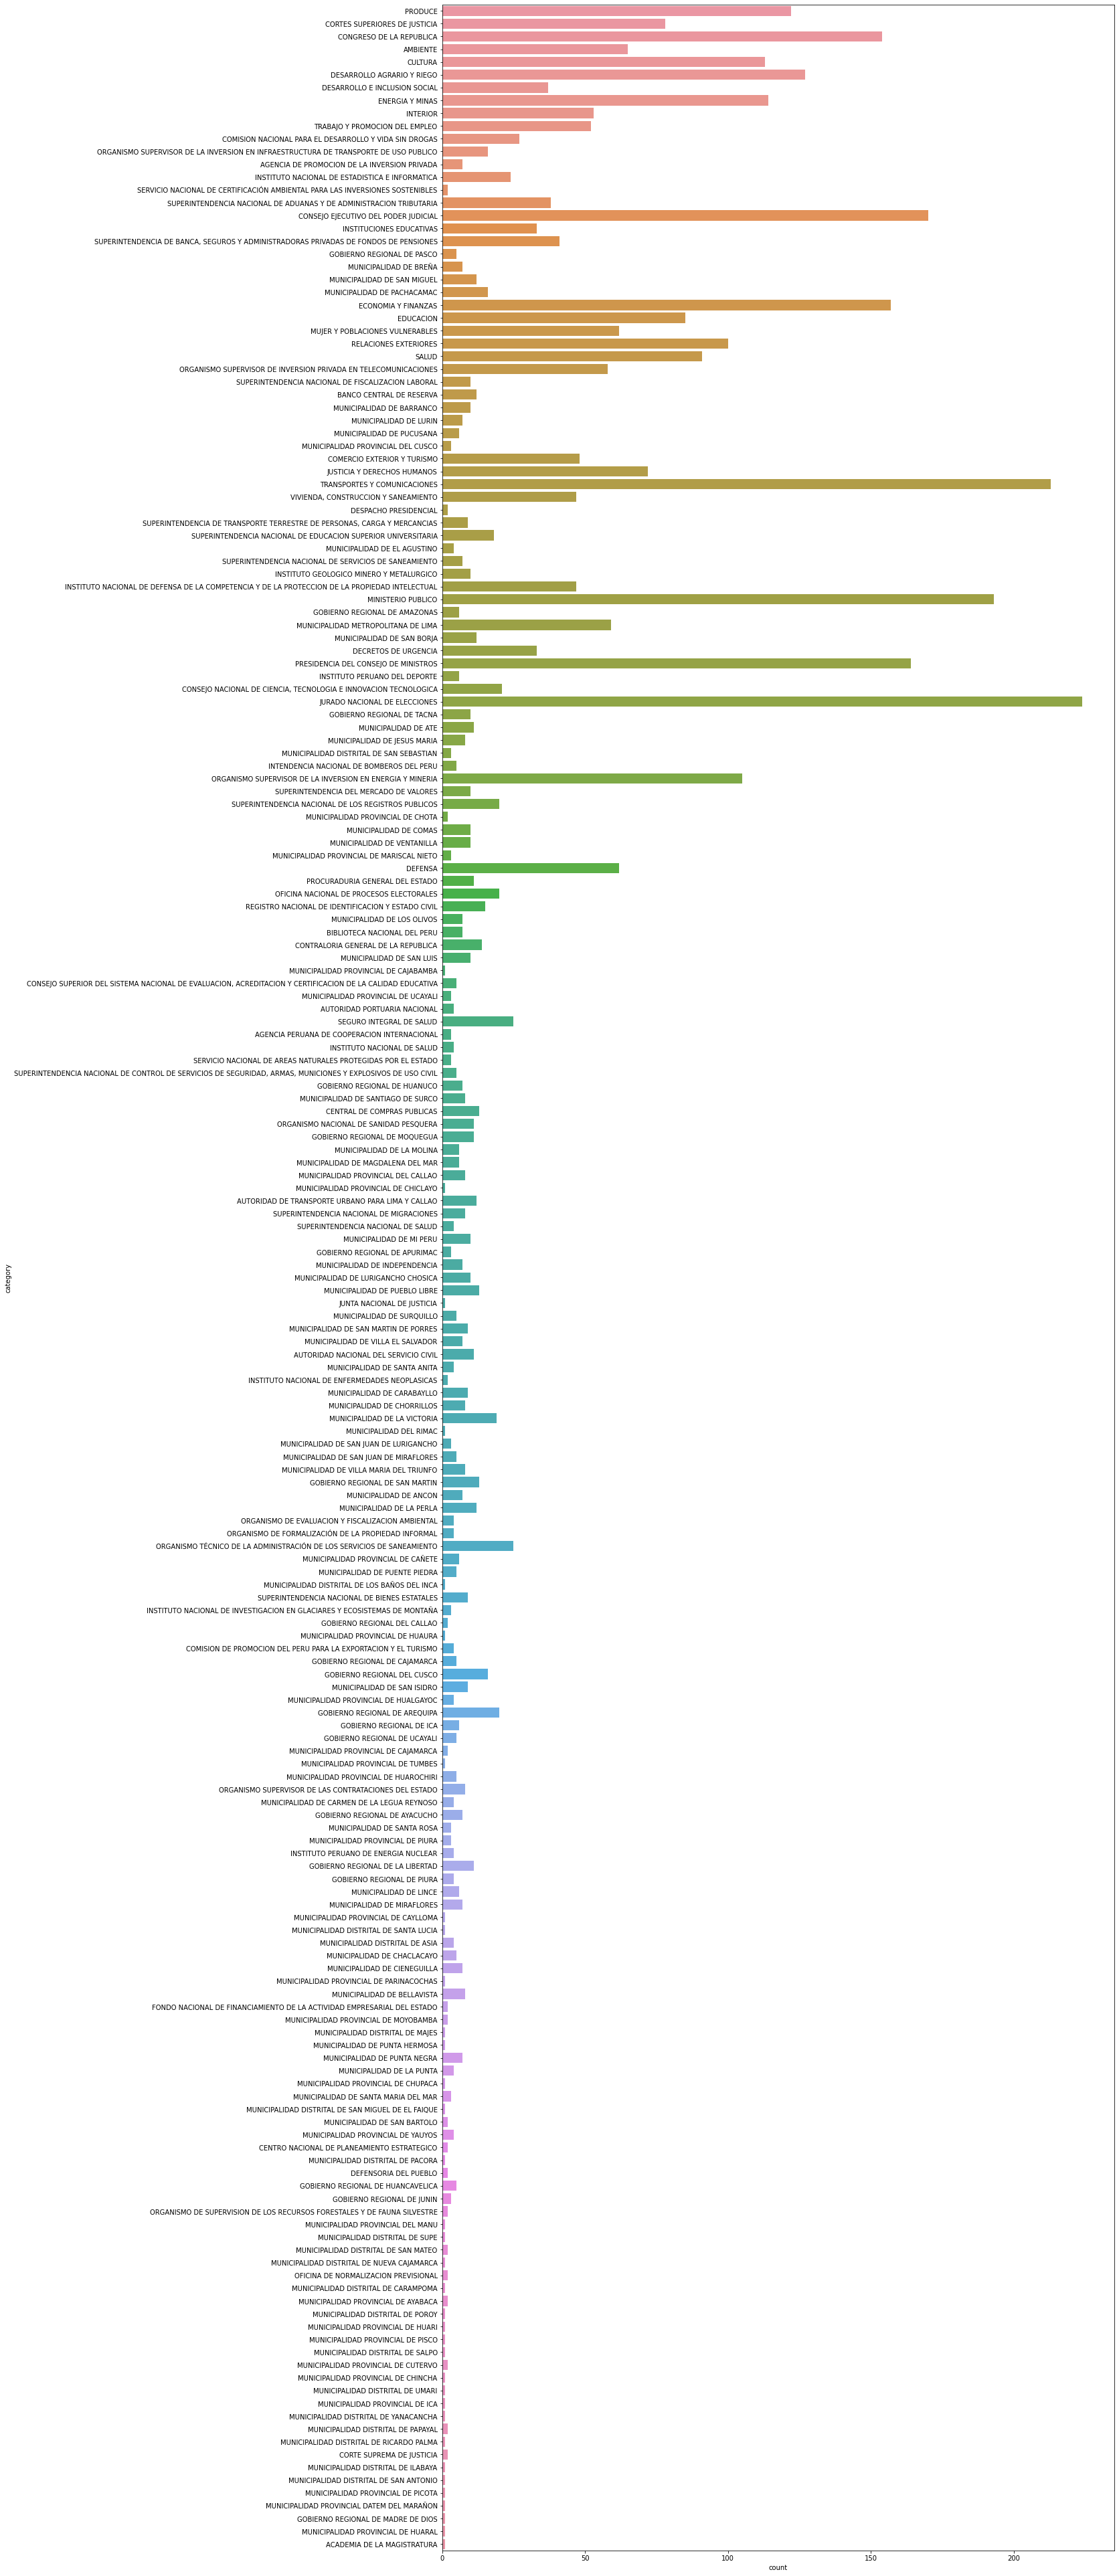

In [6]:
%%time
plt.figure(figsize=(18,70))
sns.countplot(y='category', data=dataset_base, orient='h')

___
Verificacióndel corpus
___

In [7]:
%%time
frec = FreqDist(word_tokenize(' '.join(dataset_base['content_for_topic'])))
frec.most_common(10)

CPU times: user 12.8 s, sys: 59 ms, total: 12.9 s
Wall time: 12.9 s


[('resolución', 25554),
 ('decreto', 24011),
 ('nacional', 21534),
 ('general', 20508),
 ('público', 17901),
 ('presente', 16943),
 ('mediante', 16843),
 ('supremo', 15778),
 ('reglamento', 13784),
 ('informe', 13578)]

In [8]:
# Tamaño de arreglo de palabras
print("Total de palabras del vacabulario:", len(frec))
print("Total de palabras que represetn lso tokens:", frec.N())

Total de palabras del vacabulario: 30414
Total de palabras que represetn lso tokens: 2892443


## III. Configurar el dataset para el Topic Modelling

___
Confirgurar y realizar proceso de vectorización/diccionario del contenido
___

In [9]:
%%time

# Representación vectorizada de todo el texto con TF-IDF
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : Frecuencia máxima de documentos para la palabra procesada
    max_features=20000, # max_features: númerp máximo de palabras
    min_df=0.01, # min_df : Frecuencia mínima para la palabra procesada
    use_idf=True, # use_idf: Si es falso solo calcula TF
    ngram_range=(1,1) # ngram_range: (min, max), p.e. (1, 2)incluye 1-gram, 2-gram
)

# Aplicamos el modelo 
tfidf_matrix = tfidf_model.fit_transform(dataset_base.content_for_topic) 

print("="*50)
print("En total hay {} filas (normas legales) y {} terminos.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))
print("="*50)

En total hay 4063 filas (normas legales) y 3224 terminos.
CPU times: user 1.47 s, sys: 4.23 ms, total: 1.47 s
Wall time: 1.47 s


___
Realizar validación cruzada para encontrar el mejor número de clusters (Hiperparáemtro).  
Se utiliza Latent Dirichlet Allocation (LDA)
___

In [10]:
%%time

# Prámetros a optimizar
#grid_params = {'n_components': list(range(1,6))}
grid_params = {'n_components': [5, 7, 10], 'learning_decay': [.5, .7, .9]}

# Modelo lda
lda = LatentDirichletAllocation()

#validación cruzada
lda_model = GridSearchCV(lda,param_grid=grid_params, verbose=1, n_jobs=20)
lda_model.fit(tfidf_matrix)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  45 out of  45 | elapsed:  1.4min finished


CPU times: user 10.3 s, sys: 355 ms, total: 10.6 s
Wall time: 1min 34s


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=20,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 7, 10]},
             verbose=1)

In [11]:
%%time
lda_model1 = lda_model.best_estimator_
print("Mejores parámetros para el modelo LDA:" , lda_model.best_params_)
print("Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA",lda_model.best_score_)
print("Compljedidad del modelo LDA", lda_model1.perplexity(tfidf_matrix))

Mejores parámetros para el modelo LDA: {'learning_decay': 0.7, 'n_components': 5}
Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA -64399.67327124381
Compljedidad del modelo LDA 2880.6122388598765
CPU times: user 951 ms, sys: 3.8 ms, total: 955 ms
Wall time: 953 ms


## III. Topic Modelling

___
Ejecutar el modelo con los mejores parámetros (Tópicos y gradiente del Leaning Rate)
___

In [12]:
%%time
n_topics = 5
n_learning_decay=0.9
lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=n_learning_decay, verbose=True).fit(tfidf_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 10 s, sys: 2.75 ms, total: 10.1 s
Wall time: 10 s


___
Revisar los valores generados los tópicos generados
___

In [13]:
%%time
#  Aplicar la transformación para obtener los datos
lda_data = lda.transform(tfidf_matrix)
lda.components_[0], lda_data.shape

CPU times: user 636 ms, sys: 0 ns, total: 636 ms
Wall time: 635 ms


(array([0.49702748, 0.32438915, 4.17863278, ..., 0.5037157 , 4.31673303,
        0.38447541]),
 (4063, 5))

___
Revisar el valor de cada fila/registro (norma legal) dentro de cada tópico. 

In [14]:
%%time
# Nombres de columnas
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# Norma legal indexada
doc_names = ["Norma " + str(i) for i in range(tfidf_matrix.shape[0])]

# Crear un dateset los valores del tópico y el registro
df_document_topic = pd.DataFrame(np.round(lda_data, 3), columns=topic_names, index=doc_names)

# Obtener el tópico dominate pro cada registro
topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic['TOPIC'] = topic
df_document_topic.sample(10)

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 2.78 ms


,Topic0,Topic1,Topic2,Topic3,Topic4,TOPIC
Norma 3473,0.017,0.018,0.018,0.498,0.449,3
Norma 903,0.023,0.023,0.023,0.908,0.023,3
Norma 2169,0.671,0.022,0.022,0.262,0.022,0
Norma 1630,0.022,0.022,0.022,0.910,0.023,3
Norma 620,0.021,0.021,0.021,0.021,0.916,4
Norma 1641,0.025,0.024,0.905,0.023,0.023,2
Norma 3769,0.931,0.017,0.017,0.017,0.017,0
Norma 3366,0.016,0.015,0.016,0.119,0.834,4
Norma 1272,0.019,0.564,0.382,0.017,0.018,1
Norma 2685,0.020,0.020,0.020,0.919,0.020,3


___
Total registros por tópico
___

In [15]:
# Total de registros (normas legales) por tópico
df_document_topic.TOPIC.value_counts().to_frame()

,TOPIC
3,1874
0,602
2,593
4,570
1,424


In [17]:
# Crear dataset de palabras por tópico
df_topic_words01 = pd.DataFrame(lda.components_)

# Datos de columna e índice
df_topic_words01.columns = tfidf_model.get_feature_names()
df_topic_words01.index = topic_names

df_topic_words01

,abandono,abarcar,abastecimiento,abierto,abocar,abogada,abogado,abonar,abordar,abril,...,óptico,óptimo,órden,órgano,óscar,último,única,únicamente,único,útil
Topic0,0.497027,0.324389,4.178633,1.014544,0.200004,0.202224,0.703357,0.413303,0.373768,1.280981,...,0.200009,1.318108,1.254539,7.395790,3.328849,3.710561,0.302537,0.503716,4.316733,0.384475
Topic1,0.200047,0.200072,0.616792,0.200070,0.200006,18.415790,19.755437,0.200303,0.216740,2.602542,...,0.200017,0.201532,0.204567,0.227046,0.246516,1.292308,0.200373,1.255849,6.089565,0.208657
Topic2,0.200573,0.296966,0.203791,0.231362,0.678672,2.465170,6.533240,0.713261,0.318449,6.895736,...,0.200091,0.763969,0.214064,13.287480,0.225566,3.808779,0.200739,1.043468,6.097674,0.228145
Topic3,1.262746,0.829163,3.751958,1.579068,0.200002,0.201460,0.212751,0.743945,0.836267,13.739343,...,3.477132,0.776309,1.015851,12.789837,0.498907,5.798798,1.587415,2.080508,35.109918,2.410244
Topic4,1.094874,0.336169,0.973669,1.109970,0.200003,0.211976,0.496110,0.260378,0.221074,4.332736,...,0.201123,0.302810,0.559866,7.734767,0.246769,2.363688,0.329505,1.818651,14.050490,0.389344


<AxesSubplot:>

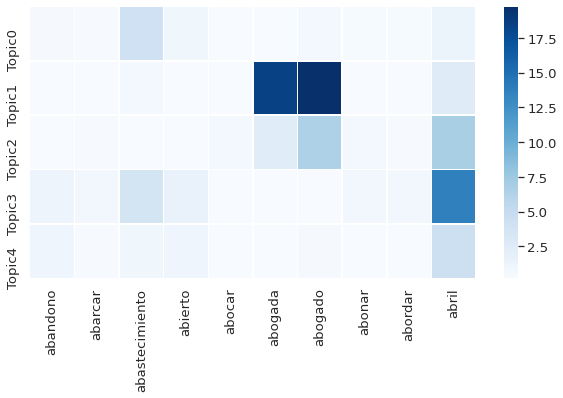

In [18]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)
sns.heatmap(
            df_topic_words01.iloc[:,:10],
            linewidth=0.5,
            cmap="Blues",
            annot=False,
            fmt=".2g",
            cbar=True
        )

___
Imprimr las primeras 10 palabras asociadas a cada tópico
___

In [19]:
%%time

# Función para imprimir las 10 principales palabras  por cada tópico
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # Por cada tópico se considera el peso
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=10)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words.T



CPU times: user 5.07 ms, sys: 65 µs, total: 5.13 ms
Wall time: 4.45 ms


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Word 0,salud,fiscal,electoral,regional,municipalidad
Word 1,presupuesto,fiscalía,judicial,decreto,ordenanza
Word 2,decreto,provincial,elección,resolución,municipal
Word 3,educación,despacho,corte,nacional,gerencia
Word 4,ministerio,cargo,resolución,general,tributario
Word 5,recurso,designar,acta,supremo,distrital
Word 6,general,distrito,justicia,ministerio,concejo
Word 7,transferencia,ministerio,juez,reglamento,alcalde
Word 8,público,junta,superior,servicio,alcaldía
Word 9,nacional,ministro,jurado,público,administrativo


In [20]:
df_topic_words01.iloc[:,:5]

,abandono,abarcar,abastecimiento,abierto,abocar
Topic0,0.497027,0.324389,4.178633,1.014544,0.200004
Topic1,0.200047,0.200072,0.616792,0.200070,0.200006
Topic2,0.200573,0.296966,0.203791,0.231362,0.678672
Topic3,1.262746,0.829163,3.751958,1.579068,0.200002
Topic4,1.094874,0.336169,0.973669,1.109970,0.200003
